In [1]:
# Importa le librerie necessarie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma, lognorm, norm, expon, poisson
from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity
from scipy.stats import gamma, lognorm, norm
from scipy.stats import kstest
from statsmodels.distributions.empirical_distribution import ECDF

# Loading Dataset and Histogram of Losses

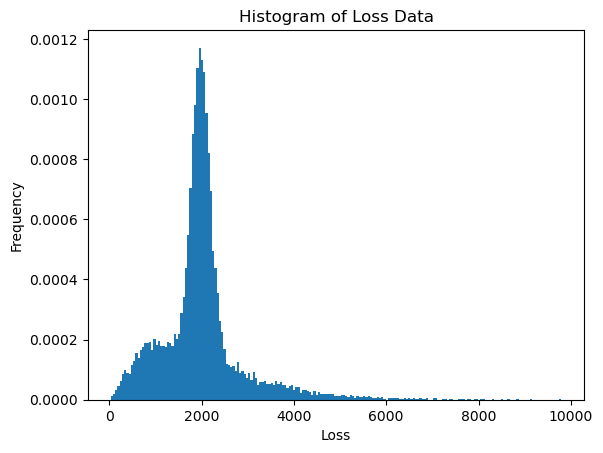

In [9]:
# Caricamento del dataset (sostituisci 'danish.csv' con il percorso del tuo file)
L = pd.read_csv('Data_Morris.txt')# Assumendo che il dataset si chiami 'danish.csv'
L_array = L.squeeze().values  # Convert DataFrame to 1D array if necessary

# Creare un istogramma delle perdite
plt.figure()
plt.hist(L, bins=200, density=True)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Loss Data')
plt.show()

In [20]:
len(L)

20000

We can see there is a peak in transition around 2000 €. The range of Loss goes from 30€ to 9797€. The total number of 
sinister is 20.000.

# Empirical Distribution and Dimension of Losses

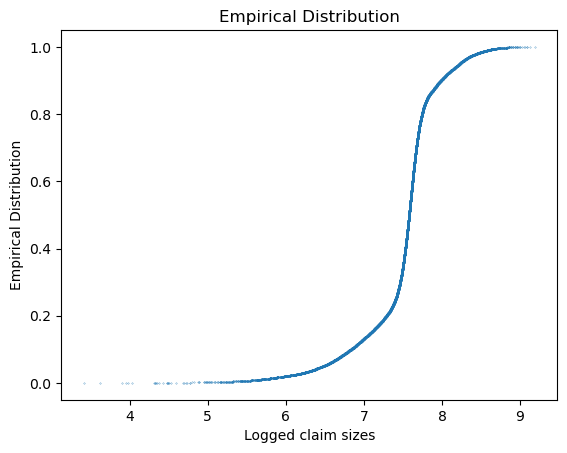

In [10]:
# Distribuzione empirica
x = np.sort(L_array)
F = np.arange(1, len(x) + 1) / len(x)

# Grafico della distribuzione empirica
plt.figure()
plt.scatter(np.log(x), F, s=0.05)
plt.xlabel('Logged claim sizes')
plt.ylabel('Empirical Distribution')
plt.title('Empirical Distribution')
plt.show()

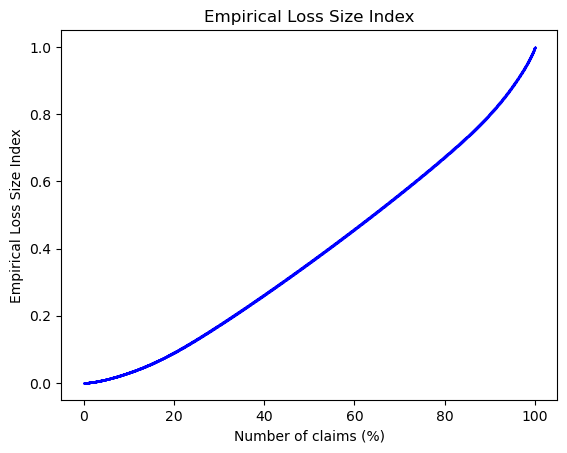

In [14]:
Ix = np.zeros(len(x))
E = np.zeros(len(x))

# Calculate Loss Size Index and Excess Function
for i in range(len(x)):
    Ind = x <= x[i]  # Boolean mask for losses ≤ current loss
    Ix[i] = np.mean(x * Ind) / x.mean()  # Loss Size Index, mean over all array
    E[i] = np.mean((x - x[i]) * (x > x[i]))  # Excess function, mean over all array

# Define cumulative percentages for the x-axis
F = np.linspace(0, 100, len(x))

# Plotting
plt.figure()
plt.scatter(F, Ix, s=0.05, color='blue')
plt.xlabel('Number of claims (%)')
plt.ylabel('Empirical Loss Size Index')
plt.title('Empirical Loss Size Index')
plt.show()

# Kernel and Mean Excess

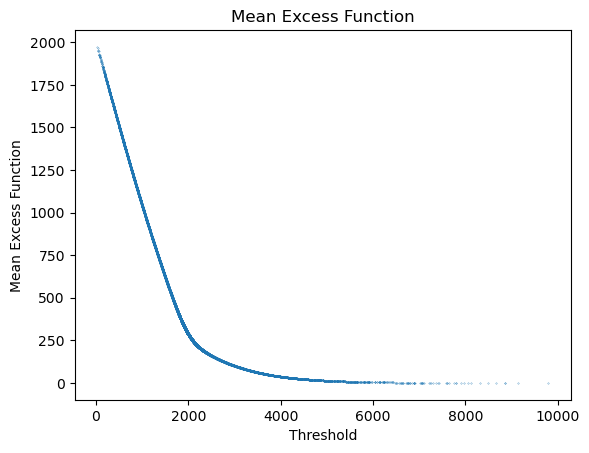

In [15]:
# Funzione mean Excess
plt.figure()
plt.scatter(x, E, s=0.05)
plt.xlabel('Threshold')
plt.ylabel('Mean Excess Function')
plt.title('Mean Excess Function')
plt.show()

Bandwidth 132.36


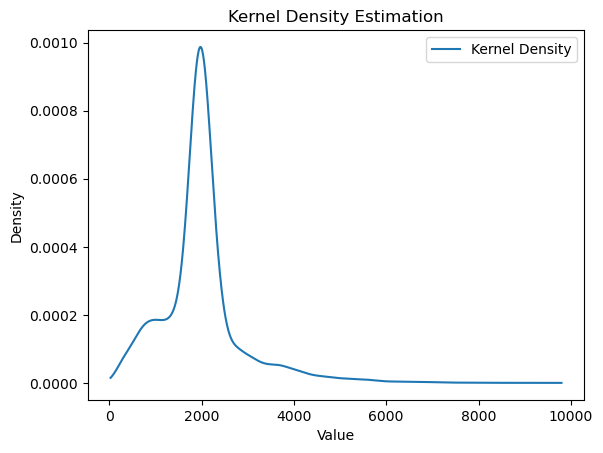

In [16]:
# Kernel Density Estimation
bdw = 1.06 * np.std(L_array) * (len(L_array))**(-1/5)  # bdw rule of thumb
print('Bandwidth {:.2f}'.format(bdw))

kde = KernelDensity(kernel='gaussian', bandwidth=bdw).fit(L_array[:, None]) 

# Generate values for density estimation
X_dens = np.linspace(L_array.min(), L_array.max(), 1000)[:, None]

# Compute log density
log_dens = kde.score_samples(X_dens)

# Plot the density
plt.figure()
plt.plot(X_dens, np.exp(log_dens), label='Kernel Density')
plt.title('Kernel Density Estimation')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# Fit 

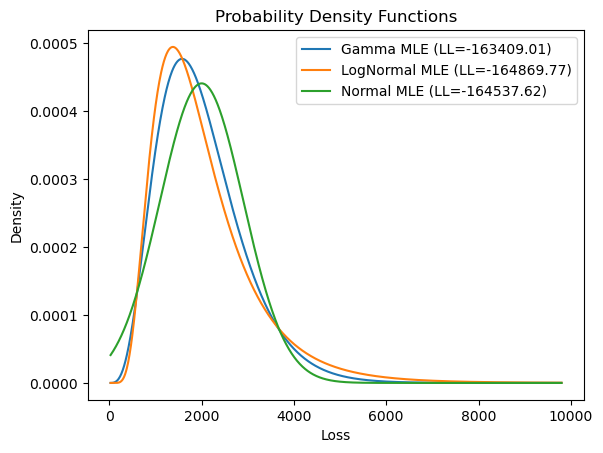

In [169]:
# Method of Moments for Gamma
M = np.mean(L_array)  # Sample Mean
S = np.std(L_array)   # Sample Standard Deviation
theta = S**2 / M      # MoM estimate for theta
k = M / theta         # MoM estimate for k

# Maximum Likelihood Estimation (MLE)
# Gamma
params_gamma = gamma.fit(L_array, floc=0)  # Fixed location at 0
LL_Gamma = np.sum(np.log(gamma.pdf(L_array, *params_gamma)))

# LogNormal
params_lognorm = lognorm.fit(L_array, floc=0)  # Fixed location at 0
LL_Logn = np.sum(np.log(lognorm.pdf(L_array, *params_lognorm)))

# Normal
params_norm = norm.fit(L_array)
LL_Norm = np.sum(np.log(norm.pdf(L_array, *params_norm)))

# Plot the estimated distributions
x_vals = np.linspace(min(L_array), max(L_array), 1000)
plt.figure()
plt.plot(x_vals, gamma.pdf(x_vals, *params_gamma), label=f'Gamma MLE (LL={LL_Gamma:.2f})')
plt.plot(x_vals, lognorm.pdf(x_vals, *params_lognorm), label=f'LogNormal MLE (LL={LL_Logn:.2f})')
plt.plot(x_vals, norm.pdf(x_vals, *params_norm), label=f'Normal MLE (LL={LL_Norm:.2f})')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.title('Probability Density Functions')
plt.legend()
plt.show()

# Empirical and Bootstrap CDF

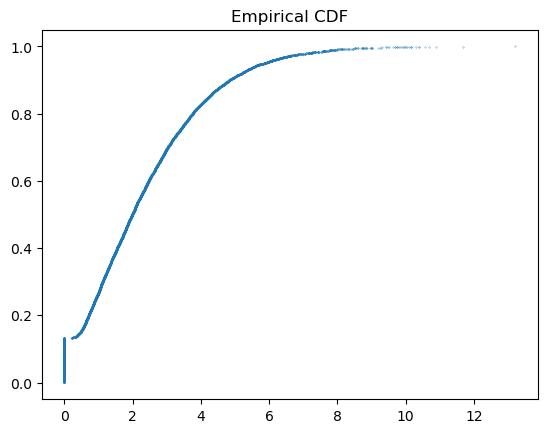

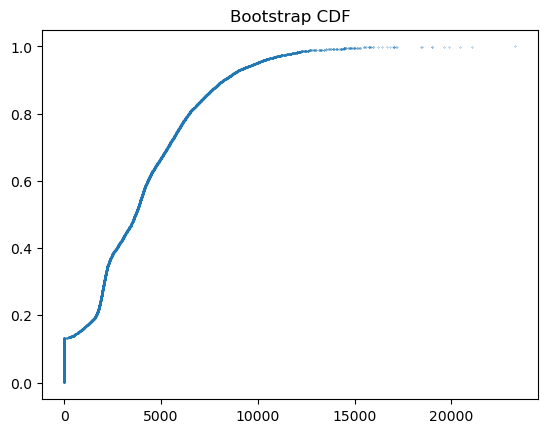

In [141]:
h1 = kstest(L_array, 'gamma', args=params_gamma)
h2 = kstest(L_array, 'lognorm', args=params_lognorm)
h3 = kstest(L_array, 'norm', args=params_norm)

# AIC e BIC
AIC_Gamma = 2 * 2 - 2 * LL_Gamma
AIC_Logn = 2 * 2 - 2 * LL_Logn
AIC_Norm = 2 * 2 - 2 * LL_Norm

BIC_Gamma = 2 * np.log(len(L)) - 2 * LL_Gamma
BIC_Logn = 2 * np.log(len(L)) - 2 * LL_Logn
BIC_Norm = 2 * np.log(len(L)) - 2 * LL_Norm


# Simulazione Monte Carlo per il portafoglio di polizze
lambda_poisson = 2
num_policies = 10000

Nsin = poisson.rvs(lambda_poisson, size=num_policies)
Loss = np.zeros(num_policies)

for i in range(num_policies):
    Loss[i] = np.sum(lognorm.rvs(params_lognorm[0], params_lognorm[1], size=Nsin[i]))


# Esempio di calcolo del premio puro usando il principio della varianza
Vt = lambda_poisson * np.exp(2 * params_lognorm[0] + params_lognorm[1]**2) * (np.exp(params_lognorm[1]**2) - 1) + lambda_poisson * (np.exp(params_lognorm[0] + params_lognorm[1]**2 / 2))**2
Vare = np.var(Loss)
car_var = 0.00001
Premiot_var = (1 + car_var) * Vt
Premioe_var = (1 + car_var) * Vare


ecdf = ECDF(Loss)
plt.figure()
plt.scatter(ecdf.x, ecdf.y, s=0.05)
plt.title('Empirical CDF')
plt.show()

# Metodo Bootstrap
Lossb = np.zeros(num_policies)
for i in range(num_policies):
    Lossb[i] = np.sum(np.random.choice(L_array, Nsin[i], replace=True))

# Visualizzazione della CDF bootstrap
ecdf_b = ECDF(Lossb)
plt.figure()
plt.scatter(ecdf_b.x, ecdf_b.y, s=0.05)
plt.title('Bootstrap CDF')
plt.show()